# Neural Style Transfer (TensorFlow)
Yang Xi <br>
22 Jul 2020

This notebook will illustrate neural styple transfer, an interesting application of Convolution Nerual Network (CNN), as created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)<br>
It will merge two input images, one representing the content (**C**) and the other representing the style (**S**), into a generated image (**G**) with the content image in the given style.<br>
The model will be trained using transfer learning based on a pretrained VGG19 model from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".<br>
Part of this code is due to deeplearning.ai and MatConvNet team for the utilities to facilitate this model.

<br>

- Define Helper Functions
	- Load VGG19 Utilities
	- Compute Conetent Cost
	- Compute Style Cost
	- Compute Total Cost
- Generate Image with Input Content and Style Images
	- Load Pre-Trained VGG19 Model
	- Define Content Cost and Style Cost
	- Define Optimizer
	- Implement the Model
	- Display Cost along with Iterations
	- Display Content, Style and Generated Images

In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

# Define Helper Functions

### Load VGG19 Utilities
These utilities include functions to load the VGG19 model and to process images

In [2]:
from vgg19_utils import *

### Compute Content Cost
The content cost function is defined as

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [3]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar representing the content cost
    """

    m, n_H, n_W, n_C = a_C.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*m*n_H*n_W*n_C)
    
    return J_content

### Compute Style Cost
The style cost of a single layer $l$ is defined as 
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$
where $G_{gram}^{(A)}$ is the gram matrix of image A
$$G_{gram}^{(A)} = AA^T$$
<br>
The style cost is defined as
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
where $\lambda^{[l]}$ is the style weights of each layer, with
$$\sum_{l}^L\lambda^{[l]} = 1$$
Here each layer will be weighted equally.

In [4]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost of given layer
    """

    def gram_matrix(A):
        GA = tf.matmul(A, A, transpose_b=True)
        return GA

    m, n_H, n_W, n_C = a_S.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[m, -1, n_C]), perm=[0,2,1])
    a_G = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]), perm=[0,2,1])
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*n_C**2 * (m*n_H*n_W)**2)
    
    return J_style_layer

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- input tensorflow model
    STYLE_LAYERS -- A python list containing style weight of each layer
    
    Returns: 
    J_style -- tensor representing a scalar value, the style cost
    """

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_S = tf.convert_to_tensor(a_S)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

### Compuete Total Cost
The total cost is defined as
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [5]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost
    J_style -- style cost
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost
    """
    
    J = alpha*J_content + beta*J_style 
    
    return J

# Generate Image with Input Content and Style Images
The notebook was developed with `TensorFlow 1` while published in `TensorFlow 2`, so some functions have been adjusted to be compatible. 

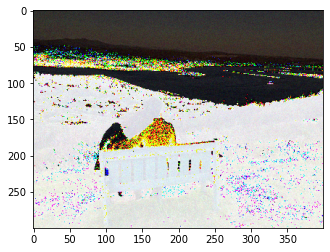

In [6]:
from matplotlib.pyplot import imread

content_image0 = "images/my_content.jpg"
style_image0 = "images/KusamaYayoi.jpg"
output_image0 = "output/generated_KusamaYayoi.jpg"


content_image = imread(content_image0)
content_image = reshape_and_normalize_image(content_image)
style_image = imread(style_image0)
style_image = reshape_and_normalize_image(style_image)

# Reset graph and initiate session
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

# Generate a noise image slightly correlated to the content image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0].astype(np.uint8))

### Load Pre-Trained VGG19 Model
Only convolution layer weights will be taken, and wrapped with TensorFlow Conv2d, Relu and AveragePooling layers.<br>
The last few fully connected layers are not used.

In [7]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Define Content Cost and Style Cost

In [8]:
# Content Cost
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_C = tf.convert_to_tensor(a_C)
a_G = out
J_content = compute_content_cost(a_C, a_G)

# Style Cost
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

### Define Optimizer

In [9]:
optimizer = tf.compat.v1.train.AdamOptimizer(1.0)

train_step = optimizer.minimize(J)

### Implement the Model

In [10]:
num_iterations = 200

def model_nn(sess, input_image, num_iterations = num_iterations):
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    lJt = []
    lJc = []
    lJs = []
    
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        
        # Save cost
        Jt, Jc, Js = sess.run([J, J_content, J_style])
        lJt.append(Jt)
        lJc.append(Jc)
        lJs.append(Js)

        # Print statistics and save images along with iterations
        if i%50 == 0:
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)

    save_image(output_image0, generated_image)

    return generated_image, lJt, lJc, lJs

generated_image, lJt, lJc, lJs = model_nn(sess, generated_image)

Iteration 0 :
total cost = 146036770000.0
content cost = 6804.317
style cost = 3650917600.0
Iteration 50 :
total cost = 31790550000.0
content cost = 37922.453
style cost = 794754240.0
Iteration 100 :
total cost = 10486255000.0
content cost = 44435.79
style cost = 262145260.0
Iteration 150 :
total cost = 5264132000.0
content cost = 47026.535
style cost = 131591550.0


### Display Cost along with Iterations

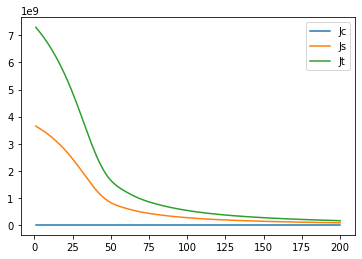

In [11]:
x = np.arange(1,num_iterations+1)

plt.plot(x, lJc, label='Jc')
plt.plot(x, lJs, label='Js')
plt.plot(x, np.array(lJt)/20, label='Jt')

plt.legend()

### Display Content, Style and Generated Images

In [12]:
import ipyplot

ipyplot.plot_images([content_image0, style_image0, 'output/50.png',
                     'output/100.png','output/150.png',output_image0],
                    ['Content Image', 'Style Image', '50 Interations',
                     '100 Interations','150 Interations','Generated Image'],
                    img_width=300, )